<a href="https://colab.research.google.com/github/yadavrishikesh/BayesNF/blob/main/BayesNF_on_Hungarian_Chickenpox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hungarian Chickenpox Tutorial

<a
target="_blank" href="https://colab.research.google.com/github/google/bayesnf/blob/main/docs/tutorials/BayesNF_Tutorial_on_Hungarian_Chickenpox.ipynb">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [3]:
# Download latest version of bayesnf.
!pip install bayesnf

In [4]:
# Install Python libraries for plotting.
!pip -q install cartopy
!pip -q install contextily
!pip -q install geopandas

In [5]:
# Load the shape file for geopandas visualization.
!wget -q https://www.geoboundaries.org/data/1_3_3/zip/shapefile/HUN/HUN_ADM1.shp.zip
!unzip -oq HUN_ADM1.shp.zip

In [6]:
import warnings
warnings.simplefilter('ignore')

import contextily as ctx
import geopandas as gpd
import jax
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from cartopy import crs as ccrs
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Loading and Plotting Data

We analyze the Hungarian Chickenpox Cases spatiotemporal dataset from the UCI machine learning repository <https://archive.ics.uci.edu/dataset/580/hungarian+chickenpox+cases>. The data contains 20 county-level time series of weekly chickenpox cases in Hungary between 2005 and 2015.

In [10]:
# Download the dataset directly using the raw file URL.
!wget -q https://raw.githubusercontent.com/yadavrishikesh/BayesNF/main/data/chickenpox.5.train.csv

# Read the downloaded CSV file into a Pandas DataFrame.
df_train = pd.read_csv('chickenpox.5.train.csv', index_col=0, parse_dates=['datetime'])

BayesNF excepts dataframe to be  in "long" format. That is, each row shows a single observation (`chickenpox` column) at a given point in time (`datetime` column) and in space (`latitude` and `longitude` columns, which show the centroid of the county). The `location` column is metadata that provides a human-readable name for the county at which measurement was recorded.

In [12]:
df_train.head(20)

,location,datetime,latitude,longitude,chickenpox
1044,BACS,2005-01-03,46.568416,19.379846,30
1045,BACS,2005-01-10,46.568416,19.379846,30
1046,BACS,2005-01-17,46.568416,19.379846,31
1047,BACS,2005-01-24,46.568416,19.379846,43
1048,BACS,2005-01-31,46.568416,19.379846,53
1049,BACS,2005-02-07,46.568416,19.379846,77
1050,BACS,2005-02-14,46.568416,19.379846,54
1051,BACS,2005-02-21,46.568416,19.379846,64
1052,BACS,2005-02-28,46.568416,19.379846,57
1053,BACS,2005-03-07,46.568416,19.379846,129


We can use the [`geopandas`](https://geopandas.org/en/stable/) library to plot snapshots the data over the spatial field at different points in time.

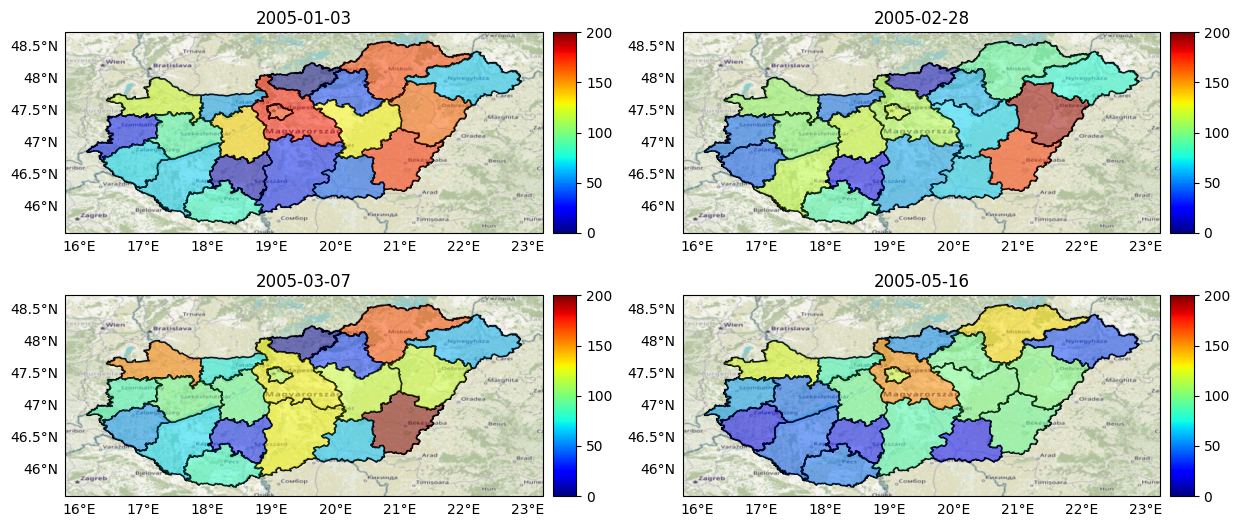

In [13]:
# Create a dataframe for plotting using geopandas.
hungary = gpd.read_file('HUN_ADM1.shp')
df_plot = df_train.copy()
df_plot['centroid'] = df_plot[['longitude','latitude']].apply(Point, axis=1)
centroid_to_polygon = {
    c: next(g for g in hungary.geometry.values if g.contains(c))
    for c in set(df_plot['centroid'])
    }
df_plot['boundary'] = df_plot['centroid'].replace(centroid_to_polygon)

# Helper function to plot a single map.
def plot_map(date, ax):
  # Plot basemap.
  hungary.plot(color='none', edgecolor='black', linewidth=1, ax=ax)
  ctx.add_basemap(ax, crs=hungary.crs.to_string(), attribution='', zorder=-1)
  # Make legend axes.
  divider = make_axes_locatable(ax)
  cax = divider.append_axes('right', size='5%', pad='2%', axes_class=plt.matplotlib.axes.Axes)
  # Set date
  # Plot stations.
  df_plot_geo = gpd.GeoDataFrame(df_plot, geometry='boundary')
  df_plot_geo_t0 = df_plot_geo[df_plot_geo.datetime==date]
  df_plot_geo_t0.plot(
      column='chickenpox', alpha=.5, vmin=0, vmax=200, edgecolor='k',
      linewidth=1, legend=True, cmap='jet', cax=cax, ax=ax)
  gl = ax.gridlines(draw_labels=True, alpha=0)
  gl.top_labels = False
  gl.right_labels = False
  ax.set_title(date)

fig, axes = plt.subplots(
    nrows=2, ncols=2, subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(12.5, 12.5), tight_layout=True)

dates = ['2005-01-03', '2005-02-28', '2005-03-07', '2005-05-16']
for ax, date in zip(axes.flat, dates):
  plot_map(date, ax)

We can also plot the observed time series at each of the 20 spatial locations. The data clarify several patterns:
- There is a low-frequency (annual) seasonal effect.
- There is possibly a higher-frequency (monthly) seasonal effect.
- Locations closer in space demonstrate the strongest cross-covariance.
- As the data is not normalized  per-capita, the amplitude of the time series (on the y-axes) generally vary across counties.

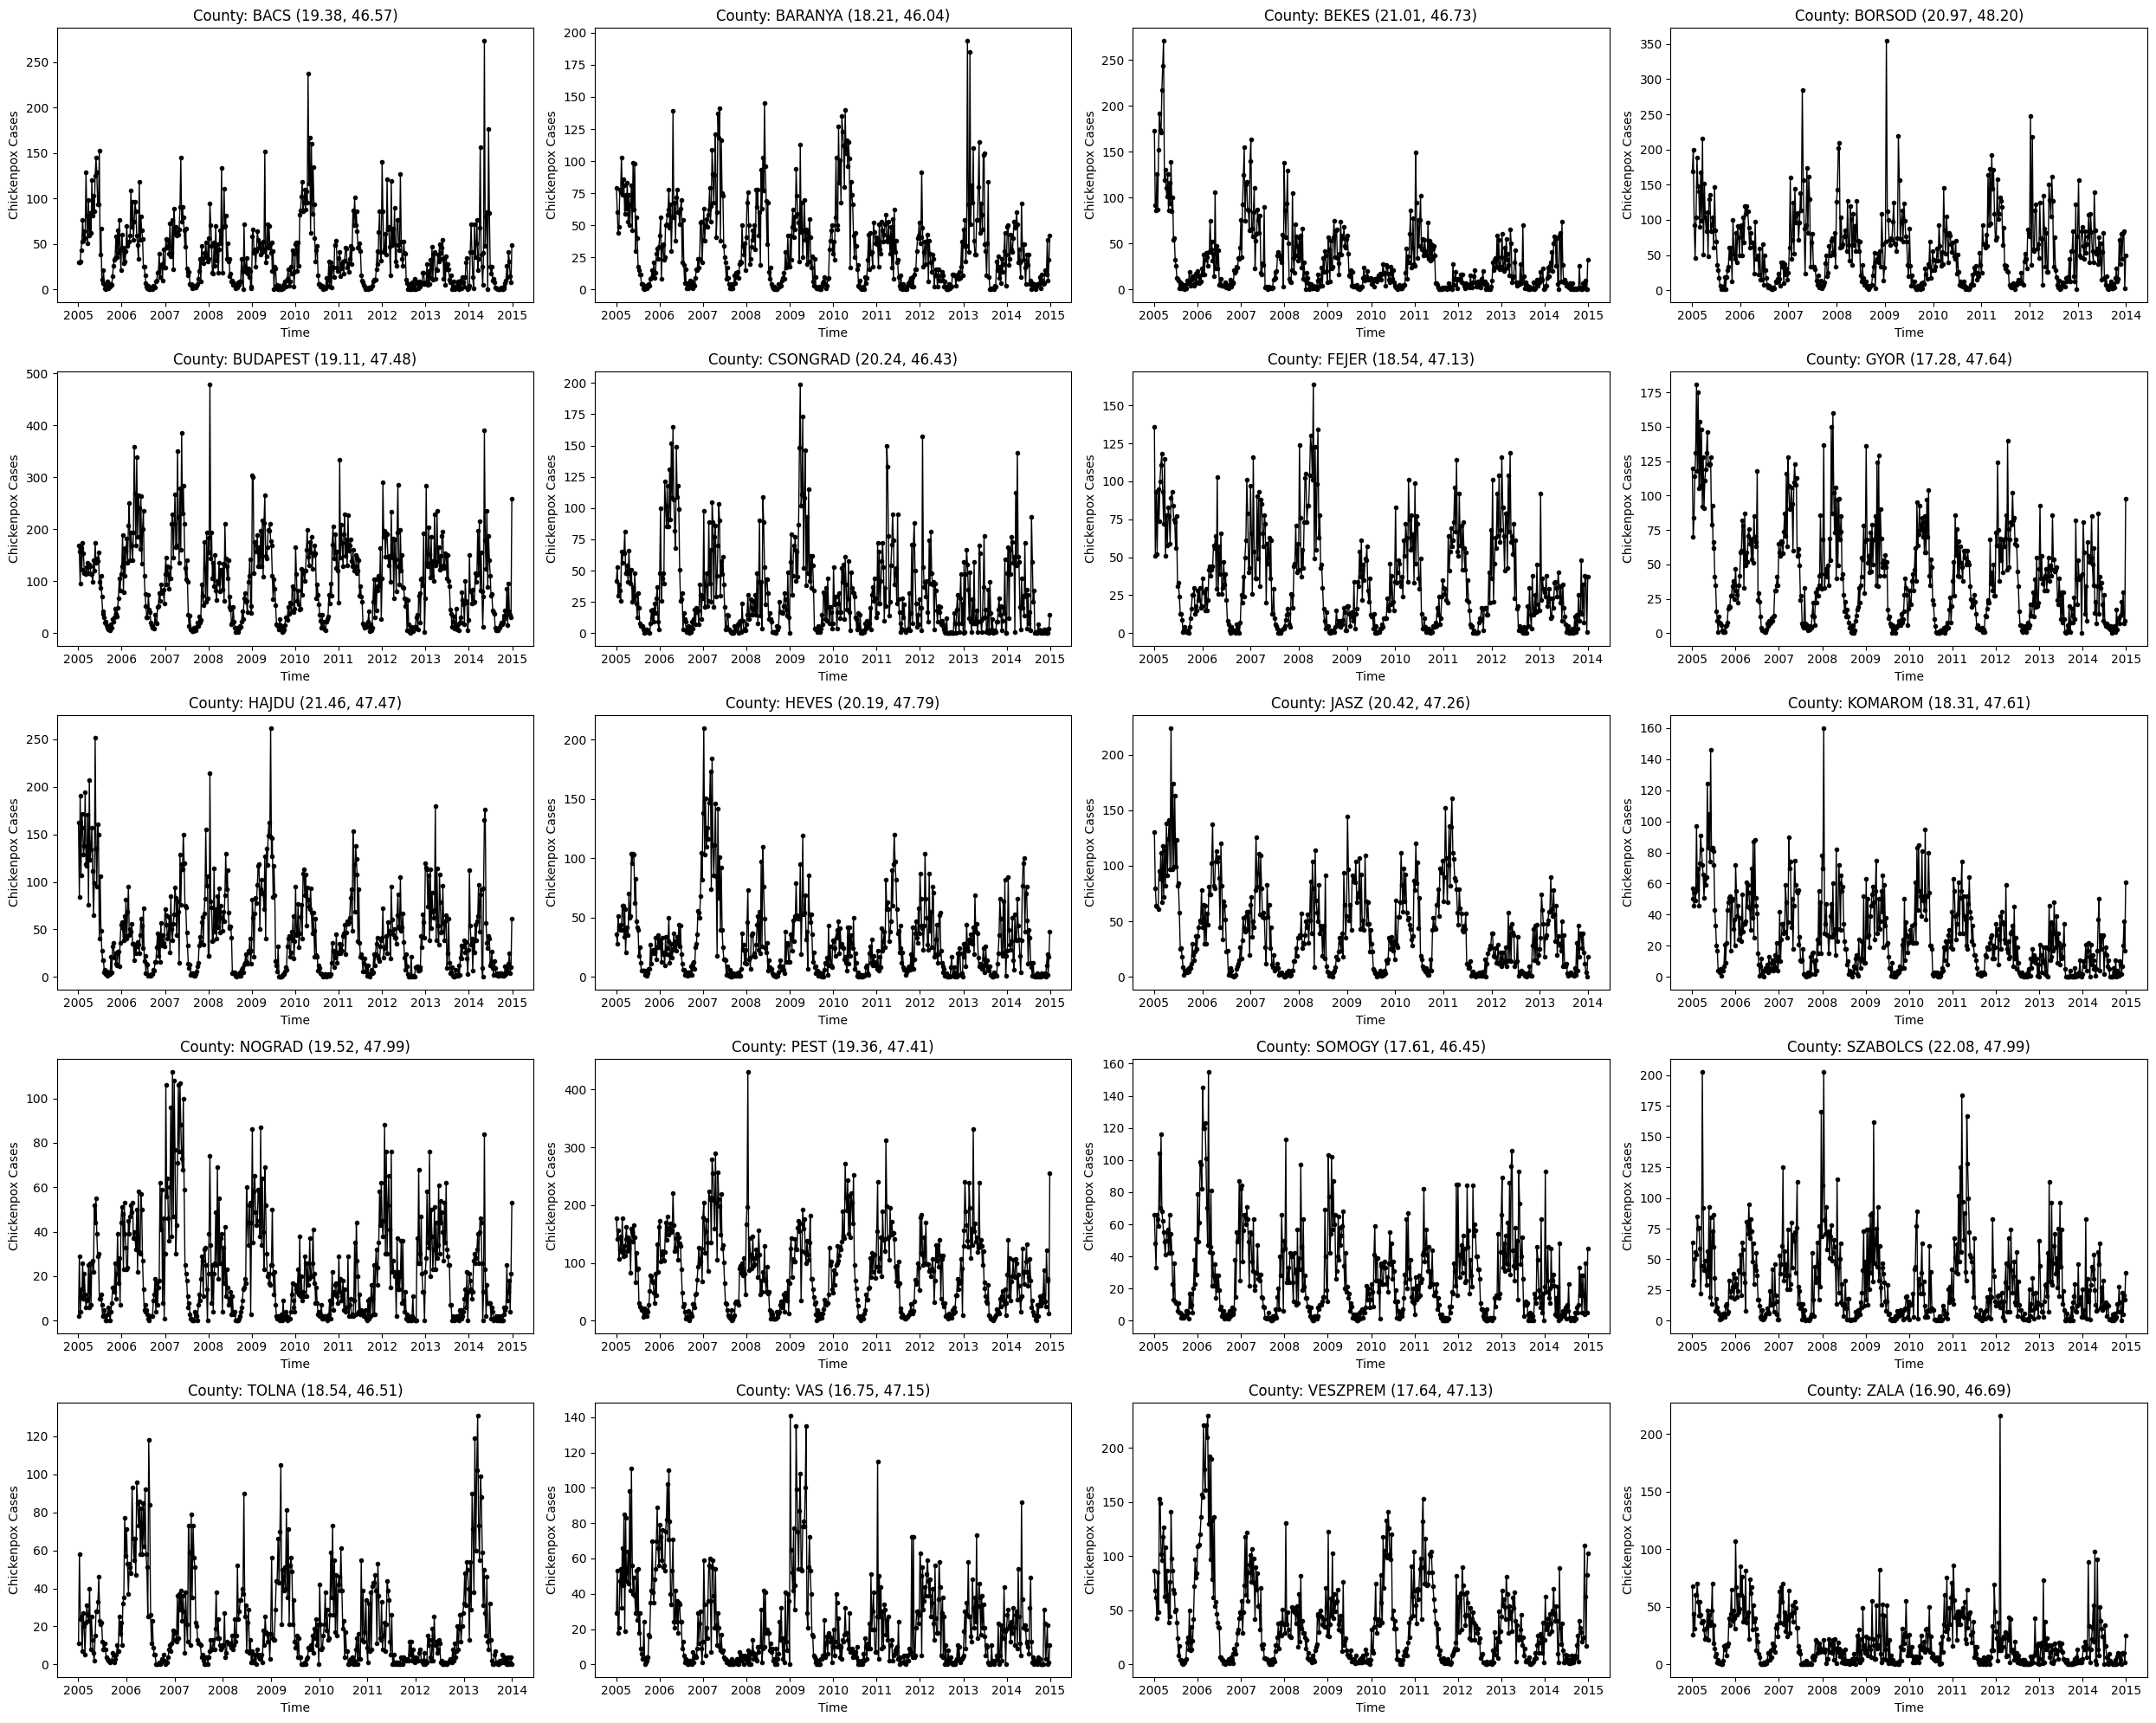

In [14]:
locations = df_train.location.unique()
fig, axes = plt.subplots(ncols=4, nrows=5, tight_layout=True, figsize=(25,20))
for ax, location in zip(axes.flat, locations):
  df_location = df_train[df_train.location==location]
  latitude, longitude = df_location.iloc[0][['latitude', 'longitude']]
  ax.plot(df_location.datetime, df_location.chickenpox, marker='.', color='k', linewidth=1)
  ax.set_title(f'County: {location} ({longitude:.2f}, {latitude:.2f})')
  ax.set_xlabel('Time')
  ax.set_ylabel('Chickenpox Cases')

# Spatiotemporal Prediction with BayesNF

The next step is to construct a BayesNF model . Since this dataset consists of areal (or lattice) measurements, we represent the spatial locations using the centroid (in `(latitude, longitude)` coordinates) of each county.

## Building an Estimator

BayesNF provides three different estimation methods:

-  [`BayesianNeuralFieldMAP`](https://google.github.io/bayesnf/api/BayesianNeuralFieldMAP/) estimator, which performs inference using stochastic ensembles of [maximum-a-posteriori](https://en.wikipedia.org/wiki/Maximum_a_posteriori_estimation) estimates.

- [`BayesianNeuralFieldVI`](https://google.github.io/bayesnf/api/BayesianNeuralFieldVI/) which uses ensemble of posterior surrogates learned using [variational Bayesian inference](https://en.wikipedia.org/wiki/Variational_Bayesian_methods).

- [`BayesianNeuralFieldMLE`](https://google.github.io/bayesnf/api/BayesianNeuralFieldMLE/), which uses an ensemble of [maximum likelihood estimates](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation).

All of these estimators satisfy the same API of the abstract [`BayesianNeuralFieldEstimator`](https://google.github.io/bayesnf/api/BayesianNeuralFieldEstimator/) class.

We will use the MAP version in this tutorial.

In [15]:
from bayesnf.spatiotemporal import BayesianNeuralFieldMAP

model = BayesianNeuralFieldMAP(
  width=256,
  depth=2,
  freq='W',
  seasonality_periods=['M', 'Y'], # equivalent to [365.25/12, 365.25]
  num_seasonal_harmonics=[2, 10], # two harmonics for M; one harmonic for Y
  feature_cols=['datetime', 'latitude', 'longitude'], # time, spatial 1, ..., spatial n
  target_col='chickenpox',
  observation_model='NORMAL',
  timetype='index',
  standardize=['latitude', 'longitude'],
  interactions=[(0, 1), (0, 2), (1, 2)],
  )

## Fitting the Estimator

All three estimators provide a `.fit` method, with slightly different signatures. The configuration below trains an ensemble comprised of 64 particles for 5000 epochs. These commands require ~120 seconds on a TPU v3-8; the `ensemble_size` and `num_epochs` values should be adjusted depending on the available resources.

In [19]:
# Train MAP ensemble
model = model.fit(
    df_train,
    seed=jax.random.PRNGKey(0),
    ensemble_size=2,
    num_epochs=1000,
    )

## Plotting Training Loss

Plotting training loss gives us a sense of convergence of the learning dynamics and agreement among differnet members of the ensemble.

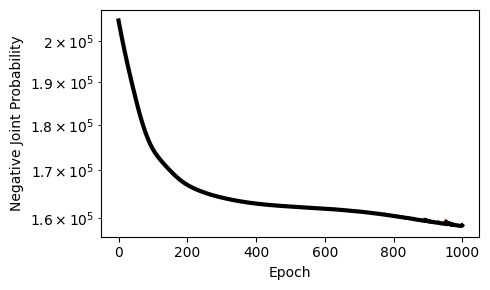

In [20]:
# Inspect the training loss for each particle.
import matplotlib.pyplot as plt
losses = np.row_stack(model.losses_)
fig, ax = plt.subplots(figsize=(5, 3), tight_layout=True)
ax.plot(losses.T)
ax.plot(np.mean(losses, axis=0), color='k', linewidth=3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Negative Joint Probability')
ax.set_yscale('log', base=10)

## Making Predictions

The `predict` method takes in

1. a test data frame, with the same format as the training data frame, except without the target column;

2. quantiles, which are a list of numbers between 0 and 1.

It returns mean predictions `yhat` and the requested quantiles `yhat_quantiles`. The `yhat` estimates are returned separately for each member of the ensemble whereas the `yhat_quantiles` estimates are computed across the entire ensemble.

In [48]:
#!wget -q https://cs.cmu.edu/~fsaad/assets/bayesnf/chickenpox.5.test.csv
#df_test = pd.read_csv('chickenpox.5.test.csv', index_col=0, parse_dates=['datetime'])
# yhat, yhat_quantiles = model.predict(df_test, quantiles=(0.025, 0.5, 0.975))

!wget -q https://raw.githubusercontent.com/yadavrishikesh/BayesNF/main/data/chickenpox.5.test.csv
df_test = pd.read_csv('chickenpox.5.test.csv', index_col=0, parse_dates=['datetime'])


Text(0, 0.5, 'Predicted Value')

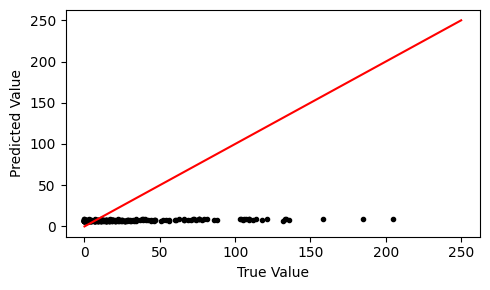

In [ ]:
fig, ax = plt.subplots(figsize=(5,3), tight_layout=True)
ax.scatter(df_test.chickenpox, yhat_quantiles[1], marker='.', color='k')
ax.plot([0, 250], [0, 250], color='red')
ax.set_xlabel('True Value')
ax.set_ylabel('Predicted Value')

We can also show the forecats on the held-out data for each of the four counties in the test set.

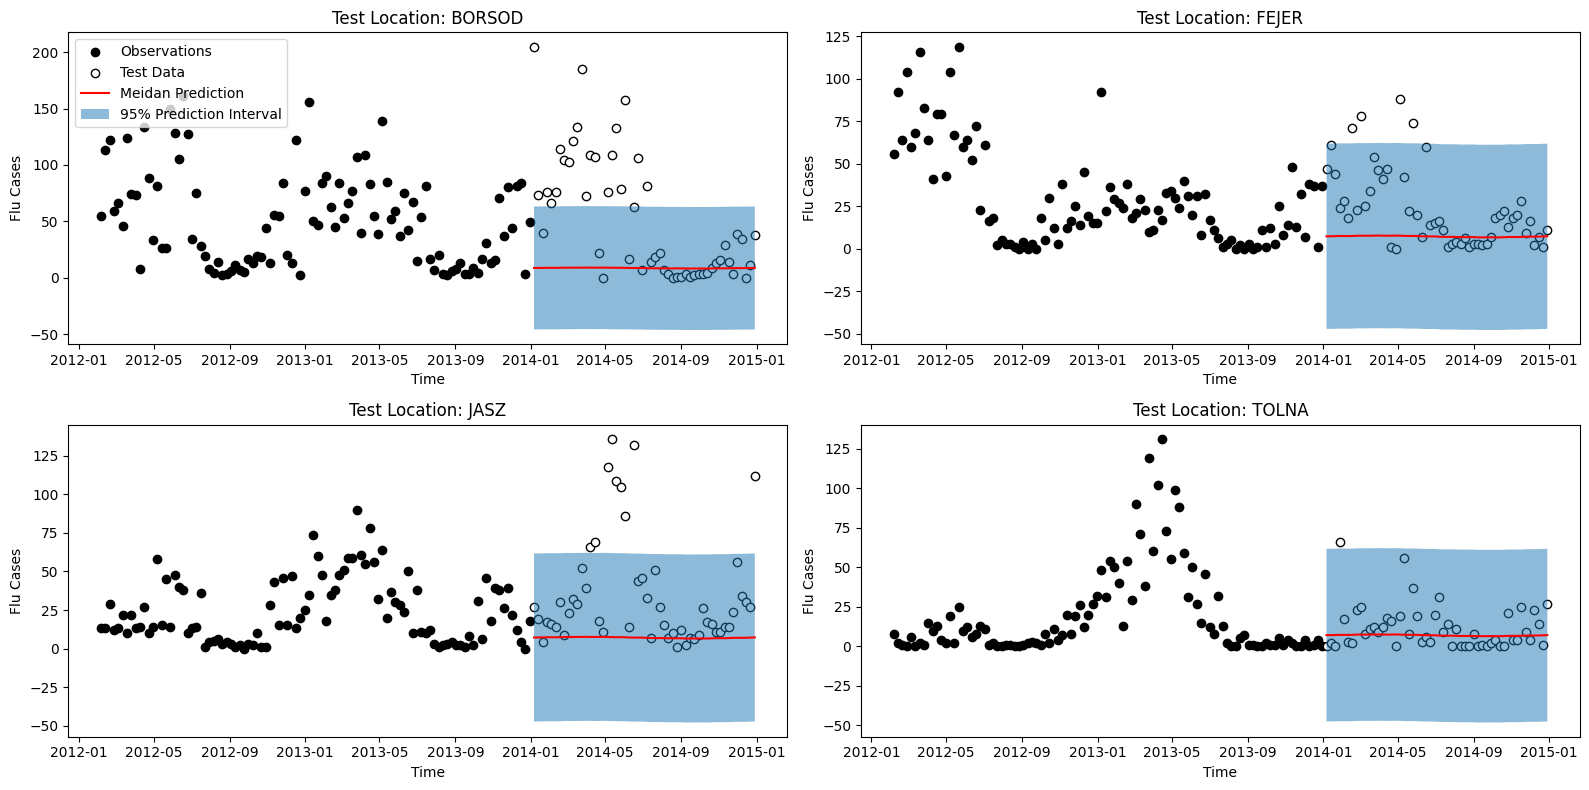

In [ ]:
locations = df_test.location.unique()
fig, axes = plt.subplots(nrows=2, ncols=len(locations)//2, tight_layout=True, figsize=(16,8))
for ax, location in zip(axes.flat, locations):
  y_train = df_train[df_train.location==location]
  y_test = df_test[df_test.location==location]
  ax.scatter(y_train.datetime[-100:], y_train.chickenpox[-100:], marker='o', color='k', label='Observations')
  ax.scatter(y_test.datetime, y_test.chickenpox, marker='o', edgecolor='k', facecolor='w', label='Test Data')
  mask = df_test.location.to_numpy() == location
  ax.plot(y_test.datetime, yhat_quantiles[1][mask], color='red', label='Meidan Prediction')
  ax.fill_between(y_test.datetime, yhat_quantiles[0][mask], yhat_quantiles[2][mask], alpha=0.5, label='95% Prediction Interval')
  ax.set_title('Test Location: %s' % (location,))
  ax.set_xlabel('Time')
  ax.set_ylabel('Flu Cases')
axes.flat[0].legend(loc='upper left')